In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io


In [230]:
# load mat file
import scipy.io as sio
#mat_contents = sio.loadmat('data/omer_Pilot_continous_psych_2023-09-26_00h46.01.195.mat')
mat_contents=sio.loadmat('data/092708_continous_psych_2023-10-13_13h45.08.071.mat')
mat_contents.keys()
sigma=mat_contents['sigma']
target=mat_contents['target'] # velocity of target motion for 1200 frames (20 seconds) and 30 trials
response=mat_contents['response'] # velocity of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
mouse_x=mat_contents['mouse_x'] # x position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
mouse_y=mat_contents['mouse_y'] # y position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
blob_x=mat_contents['blob_x'] # x position of target for trialNum200 frames (20 seconds) and 30 trials
blob_y=mat_contents['blob_y'] # y position of target for trialNum200 frames (20 seconds) and 30 trials
# get diff for velocity to find horizontal and vertical velocity
blob_x_velocity=np.diff(blob_x)
blob_y_velocity=np.diff(blob_y)
mouse_x_velocity=np.diff(mouse_x)
mouse_y_velocity=np.diff(mouse_y)
nTrial=len(sigma[0])
nSigma=6
nTrialPerBlock=nTrial//nSigma
nTrialPerSigma=nTrial//nTrialPerBlock
blob_widths=[11,13,17,21,25,29]

In [71]:
sigma
# reshape sigma as a matrix of 6x5 (6 rows and 5 columns)
sigma_matrix=np.reshape(sigma,(nTrial//5,5))

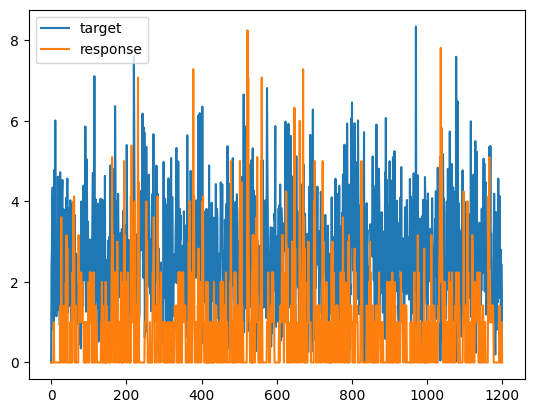

In [5]:
# plot the data
trialNum=0
plt.plot(target[trialNum,:])
plt.plot(response[1,:])
plt.legend(['target','response'])
plt.show()


In [134]:
sigma[0]

array([29, 29, 29, 29, 29, 21, 21, 21, 21, 21, 13, 13, 13, 13, 13, 11, 11,
       11, 11, 11, 25, 25, 25, 25, 25, 17, 17, 17, 17, 17])

In [196]:
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(30):
    trial_dict[i] = {'target': target[i,:], 'response': response[i,:], 'mouse_x': mouse_x[i,:], 'mouse_y': mouse_y[i,:], 'blob_x': blob_x[i,:], 'blob_y': blob_y[i,:], 'sigma': sigma[0][i]}
trial_dict[2]['sigma']


29

In [210]:

# sort the dictionary by sigma
trialDictSorted = sorted(trial_dict.items(), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
tmp_trial=trialDictSorted[3][1]


array([ 0.        ,  2.36843208,  5.9662879 , ..., 47.32618076,
       46.90865644, 50.82573031])

In [136]:
# dictionary of 5 sigma values and trialNums
sigma_dict={29:0,21:1,13:2,11:3,25:4,17:5}
# redefine sigma_dict using sigma_matrix values
for counter,blob in enumerate(sigma_matrix[:,0]):
    sigma_dict[blob]=counter
sigma_dict

{29: 0, 21: 1, 13: 2, 11: 3, 25: 4, 17: 5}

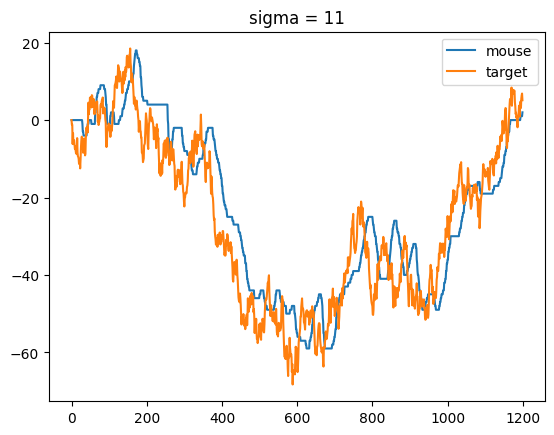

In [159]:
# plot motion trajectory for a single trial
# select trial number from sigma_dict.keys() when sigma is 11
selected_sigma = 11
trialNum= sigma_dict[selected_sigma]*5+0
trialNum=0
X=trialDictSorted[trialNum][1]['mouse_x']
Y=trialDictSorted[trialNum][1]['blob_x']
plt.plot(X)
plt.plot(Y)
plt.legend(['mouse','target'])
plt.title('sigma = '+str(trialDictSorted[trialNum][1]['sigma']))
plt.show()


In [123]:
# sigma is blob width of the target on each trial
# sigma is constant for 5 trials and then changes
# calculate mean of mouse_x and blob_x for trials with the same sigma value
# plot the mean of mouse_x and blob_x for trials with the same sigma value  (5 plots)
mean_mouse_xs=[]
mean_blob_xs=[]
mean_mouse_ys=[]
mean_blob_ys=[]
mean_mouse_vs=[]
mean_blob_vs=[]
for i in range(0,6):
    # get mean of mouse_x for trials untill sigma value changes
    mean_mouse_xs.append(np.mean(mouse_x[i*5:(i+1)*5,:], axis=0))
    # get mean of blob_x for trials untill sigma value changes
    mean_blob_xs.append( np.mean(blob_x[i*5:(i+1)*5,:], axis=0))
    mean_blob_ys.append( np.mean(blob_y[i*5:(i+1)*5,:], axis=0))
    mean_mouse_ys.append( np.mean(mouse_y[i*5:(i+1)*5,:], axis=0))
    mean_mouse_vs.append( np.mean(response[i*5:(i+1)*5,:], axis=0))
    mean_blob_vs.append( np.mean(target[i*5:(i+1)*5,:], axis=0))


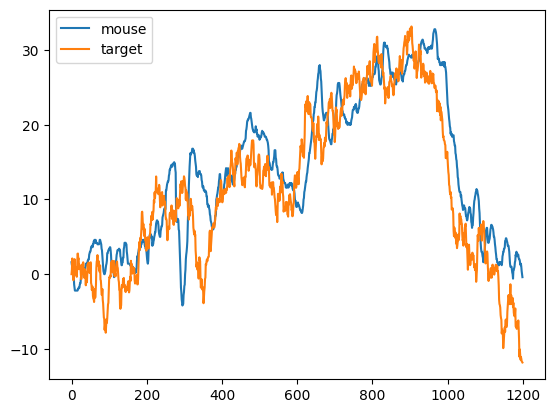

In [124]:

selected_sigma = 21
# plot the mean of mouse_x and blob_x
plt.plot(mean_mouse_xs[sigma_dict[selected_sigma]])
plt.plot(mean_blob_xs[sigma_dict[selected_sigma]])
# color the plot with the same color for the same sigma value

plt.legend(['mouse','target'])

In [125]:
sigma

array([[29, 29, 29, 29, 29, 21, 21, 21, 21, 21, 13, 13, 13, 13, 13, 11,
        11, 11, 11, 11, 25, 25, 25, 25, 25, 17, 17, 17, 17, 17]])

# Cross Correlogram

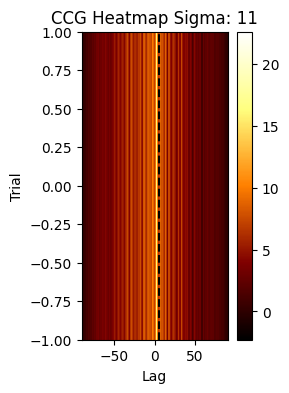

In [126]:
selected_sigma = 11
trialNum=sigma_dict[selected_sigma]*5+0
# Normalize the signals
def min_max_normalizer(x):
    return ((x-x.min())/(x.max()-x.min()))*2-1
X=min_max_normalizer(mouse_x_velocity[trialNum, :])
Y=min_max_normalizer(blob_x_velocity[trialNum, :])

ccg=  np.correlate(X, Y, 'full')
lag_range = 90
ccg_range = ccg[600 - lag_range : 601 + lag_range]
# Create a time vector for the lag range
time_vector = np.arange(-lag_range, lag_range + 1)
# Create heatmap
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow([ccg], cmap='afmhot', aspect='auto', extent=[-lag_range, lag_range, -1, 1])
plt.title('CCG Heatmap Sigma: '+ str(selected_sigma))
plt.xlabel('Lag')
plt.ylabel('Trial')
plt.colorbar()

# Trace peak
peak_index = np.argmax(ccg_range) - lag_range
plt.axvline(peak_index, color='black', linestyle='--')

# Calculate and display average
# average_corr = np.corrcoef(target[trialNum,:], response[trialNum,:])[0, 1]
# plt.subplot(1, 3, 3)
# plt.text(0.5, 0.5, f'Avg Corr: {average_corr:.2f}', ha='center', va='center', fontsize=12)
# plt.title('Cross Correlation of ' + str(selected_sigma))
# plt.axis('off')
# plt.show()

## Avarage CCG across different blob_widths

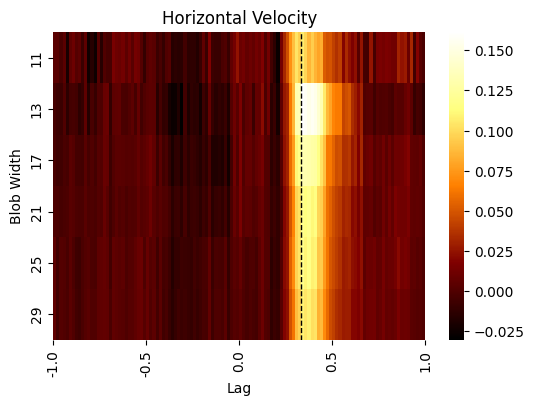

In [232]:
# avarage cross correlation for trials with the same sigma value
blob_widths=[11,13,17,21,25,29]
mean_ccgs=[]
ccg_blob_mean=[]
ccg_single_blob=[]
frameRate=60
lag_time=1 # seconds
lag_range = int(lag_time*frameRate)
len_trial=len(target[0,:])
mid_trial=int(len_trial/2)
for blob_width in range(len(blob_widths)):
    for i in range(nTrialPerBlock):
        tmp_trial=trialDictSorted[i+blob_width*nTrialPerBlock][1]
        X=tmp_trial['mouse_x']
        Y=tmp_trial['blob_x']
        # normalize X
        X=(X-np.min(X))/(np.max(X)-np.min(X))*2-1
        # normalize Y
        Y=(Y-np.min(Y))/(np.max(Y)-np.min(Y))*2-1
        ccg_single_trial= np.correlate(np.diff(X), np.diff(Y), 'full') 
        #ccg_single_trial = ccg_single_trial[len_trial - lag_range : len_trial + lag_range]
        ccg_single_blob.append(ccg_single_trial)
    ccg_blob_mean.append(np.mean(ccg_single_blob, axis=0))

# Trim ccg_blob_mean to lag_range
ccg_blob_mean=np.array(ccg_blob_mean)
ccg_blob_mean_trimmed = ccg_blob_mean[:, len_trial - lag_range : len_trial + lag_range]
# trim single ccgs
ccg_single_blob=np.array(ccg_single_blob)
ccg_single_blob_trimmed = ccg_single_blob[:, len_trial - lag_range : len_trial + lag_range]

# create heatmap for mean of cross correlation for trials with the same sigma value
plt.figure(figsize=(6, 4))
sns.heatmap(ccg_blob_mean_trimmed, cmap='afmhot',yticklabels=blob_widths)

# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*lag_time*2, 5)
labels=np.linspace(-lag_time, lag_time, len(x))
plt.xticks(x, labels, rotation='vertical')
#plt.imshow(ccg_blob_mean, cmap='afmhot', aspect='auto', yticklabels=blob_widths)
plt.title('Horizontal Velocity')
plt.xlabel('Lag')
plt.ylabel('Blob Width')

# Find lag indices of peaks in each row
peak_indices = np.argmax(ccg_blob_mean_trimmed, axis=1)
# Trace peak for each blob width
# Add peak lines to the heatmap
for i, peak_index in enumerate(peak_indices):
    plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=1, ymin=i/len(blob_widths), ymax=(i+1)/len(blob_widths))
plt.show()
#plt.colorbar()


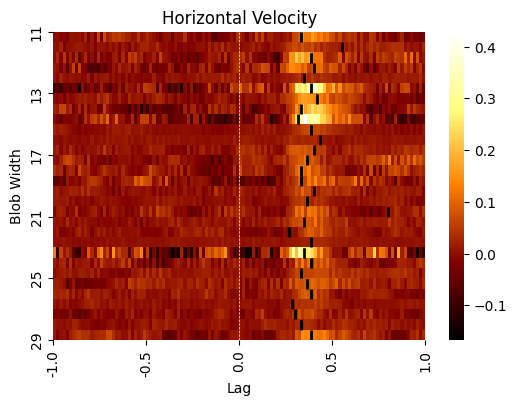

In [233]:
# create heatmap for mean of cross correlation for trials with the same sigma value
plt.figure(figsize=(6, 4))
sns.heatmap(ccg_single_blob_trimmed, cmap='afmhot')
# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*lag_time*2, 5)
labels=np.linspace(-lag_time, lag_time, len(x))
plt.xticks(x, labels, rotation='vertical')
## set y axis ticks based on blob widths so that each 5 rows are for the same blob width
yticks=np.linspace(0, len(ccg_single_blob_trimmed), 6)
yticklabels=blob_widths
plt.yticks(yticks, yticklabels)

plt.title('Horizontal Velocity')
plt.xlabel('Lag')
plt.ylabel('Blob Width')
# Find lag indices of peaks in each row
peak_indices = np.argmax(ccg_single_blob_trimmed, axis=1)
# Trace peak for each blob width
# Add peak lines to the heatmap
plt.axvline(x=lag_range,color='white',linestyle='--',linewidth=0.5)

for i, peak_index in enumerate(peak_indices):
    #plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=1, ymin=i/len(blob_widths), ymax=(i+1)/len(blob_widths))
    plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=2, ymin=i/30, ymax=(i+1)/30)
plt.show()


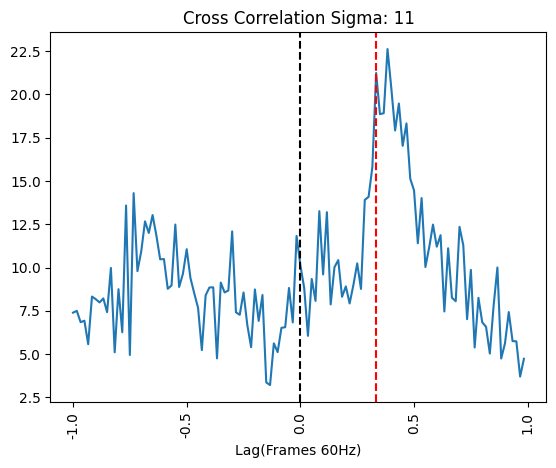

In [227]:
# plot corss-correlation for a single trial
len_trial=len(target[0,:])
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
plt.plot(ccg[len_trial-steps:len_trial+steps])
ccg=ccg_blob_mean[0]# set CCG
# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*time_lag*2, 5)
labels=np.linspace(-time_lag, time_lag, len(x))
plt.xticks(x, labels, rotation='vertical')

#plot a vertical line at lag=0
plt.axvline(time_lag*frameRate, color='black', linestyle='--')
# calculate highest correlation
max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
# plot the highest correlation
#plt.axhline(max_corr, color='black', linestyle='--')
plt.axvline(max_corr_index, color='red', linestyle='--')
plt.title('Cross Correlation Sigma: ' + str(selected_sigma))
plt.xlabel('Lag(Frames 60Hz)')
plt.show()

## Avarage CCG plots 

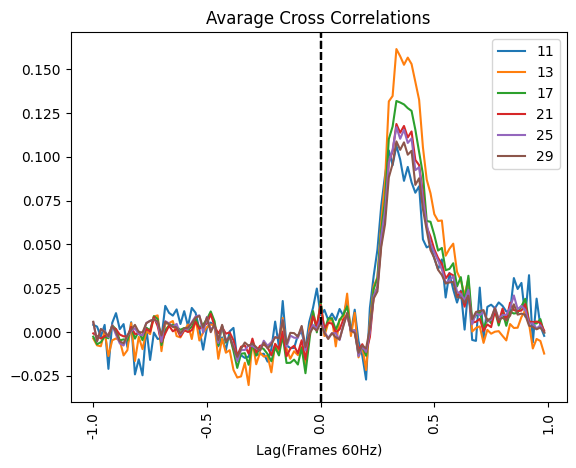

In [229]:
for i,bw in enumerate(blob_widths): 
   # plot corss-correlation for a single trial
    len_trial=len(target[0,:])
    frameRate=60
    time_lag=1 # seconds
    steps=int(frameRate*time_lag)
    # set CCG
    ccg=ccg_blob_mean[i]
    # calculate highest correlation
    max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
    max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
    # color based on bw
    plt.plot(ccg[len_trial-steps:len_trial+steps], label=bw)
    plt.legend()
    # add bw as a label
    # set x axis ticks from -120 to 120 with ticks at every 20 units
    x=np.linspace(0, frameRate*time_lag*2, 5)
    labels=np.linspace(-time_lag, time_lag, len(x))
    plt.xticks(x, labels, rotation='vertical')
    #plot a vertical line at lag=0
    plt.axvline(time_lag*frameRate, color='black', linestyle='--')
    # calculate highest correlation
    max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
    max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
    plt.title('Avarage Cross Correlations')
    plt.xlabel('Lag(Frames 60Hz)')
    # add legend
    #plt.show()



c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


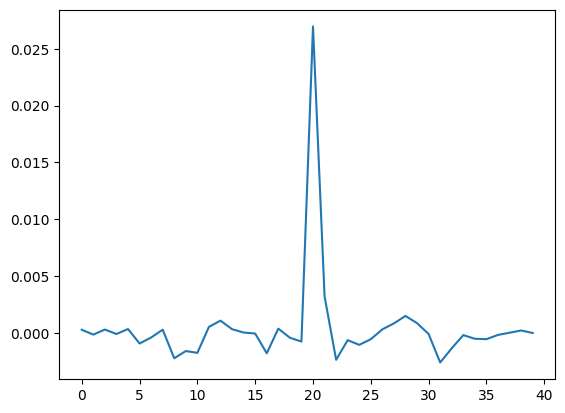

In [113]:

# plot avarage corss-correlation across 1 second (60 frame) intervals lag
avarage_ccg=[]
for i in range(0,60):
    avarage_ccg.append(np.mean(ccg[i*60:(i+1)*60]))
plt.plot(avarage_ccg)
plt.show()

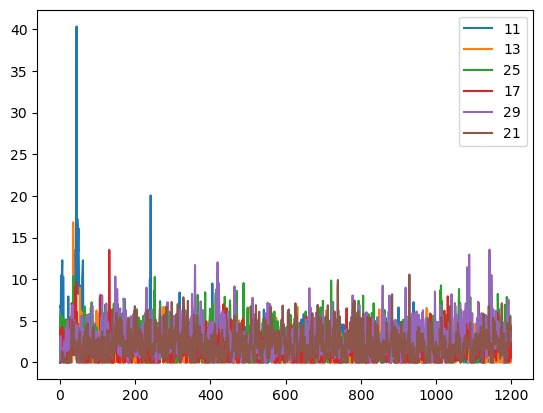

In [ ]:
# avarage cross correlogram of velocity of mouse and target motion for trials with the same sigma valu
# Figure 4. Average CCGs for blob width (curve color, identified in the legend by their r in arcmin) for each of the three observers (panel). The peak height, location of peak, and width of curve (however measured) all sort neatly by blob width, with the more visible targets yielding higher, prompter, and sharper curves. This shows that there is at least a qualitative agreement between measures of tracking performance and what would be expected from a traditional psychophysical experiment

# calculate correlation of blob_v and mouse_v value across 1200 frames 
# correlation_across_frames=[]
# blob_width=sigma_dict[13]
# for i in range(1200):
#     correlation_across_frames.append(np.correlate(target[blob_width*5:(blob_width+1)*5,i], response[blob_width*5:(blob_width+1)*5,i]))
# # plot the correlation
# plt.plot(correlation_across_frames)
# plt.show()
import scipy.signal  

##
# now create cross correlogram plot for each blob width and label them with blob width
for sigma in sigma_dict.keys():
    blob_width=sigma_dict[sigma]
    correlation_across_frames=[]    
    for i in range(1200):
        correlation_across_frames.append(np.correlate(target[blob_width*5:(blob_width+1)*5,i], response[blob_width*5:(blob_width+1)*5,i]))
    # plot the correlation
    plt.plot(correlation_across_frames, label=sigma)
plt.legend()
plt.show()
